# Sentiment Analysis Prototyping

Prototype code for ML-based sentiment analysis. Classification case pos/neutral/neg only.

In [1]:
import os, re, string, pickle, random

import numpy as np
import pandas as pd

import nltk
nltk.data.path.append("../data/external/nltk_data")
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.cistem import Cistem

import emoji

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, balanced_accuracy_score

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
random_state = 23
random.seed(random_state)

## Loading

In [3]:
data_path = "/mnt/DATA/NRW2019 Dropbox/data 4good/CSVData"
fpath = os.path.join(data_path, "TestData", "forSentAnalysis.csv")

labeled_data = pd.read_csv(fpath)
labeled_data.shape

(1056, 7)

Rating schema: {0: "positive", 10: "neutral", 20: "negative", 30: "offensive", -2: "notAssessable"}

## Preprocessing

Dataset cleansing

In [4]:
# Remove unnecessary cols and rename columns uniformly
labeled_data.drop(["id", "Level", "Topic", "sentiment"], axis=1, inplace=True)
labeled_data.columns = ["source", "text", "rating"]

# Remove not assessable and offensive texts
labeled_data = labeled_data[labeled_data.rating != -2]
labeled_data = labeled_data[labeled_data.rating != 30]

labeled_data.shape

(845, 3)

Text cleansing

In [5]:
stopwords_list = stopwords.words("german")
stemmer = Cistem()

def clean_text(text):
    """ Util: Cleans text string.
    > Lowercase string
    > Replace game scores with "GAME_SCORE" placeholder
    > Punctuation removal
    > Replace numbers with "NUM" placeholder
    > Stemming
    > Stopwords removal
    """
    lowercased = text.lower()
    scores_removed = re.sub(r"(\d+) ?(-|:) ?(\d+)", "GAME_SCORE ", lowercased)
    punctuations = string.punctuation + "„" + "”" + "–" + "‘" + "’" + "“" + "…" + "‼"
    punct_removed = scores_removed.translate(str.maketrans("", "",
                                                           punctuations))
    num_replaced = re.sub(r"\b\d+\b", "NUM", punct_removed)
    split_emoji = emoji.get_emoji_regexp().split(num_replaced) # splits emoji from words away
    tokenized = word_tokenize(" ".join(split_emoji)) 
    cleaned_tokens = [word for word in tokenized if word not in stopwords_list]
    stemmed = [stemmer.stem(word) for word in cleaned_tokens]
    cleaned_txt = " ".join(stemmed)

    return cleaned_txt

labeled_data["cleaned_txt"] = labeled_data.text.apply(clean_text)

## Exploration

NaN Stats

In [6]:
labeled_data.isna().sum()

source         0
text           0
rating         0
cleaned_txt    0
dtype: int64

Distribution of sources

In [7]:
print("Sources count:", len(labeled_data.source.value_counts()))
print("Avg count of doc per source:", np.mean(labeled_data.source.value_counts().tolist()))
print("Top 5 sources:")
labeled_data.source.value_counts()[:5]

Sources count: 49
Avg count of doc per source: 17.244897959183675
Top 5 sources:


JOY_PAMELA_RENDIWAGNER    111
DIE_KRONE                 111
FLORIAN_KLENK              89
DER_STANDARD               70
KURIER                     52
Name: source, dtype: int64

Distribution of ratings

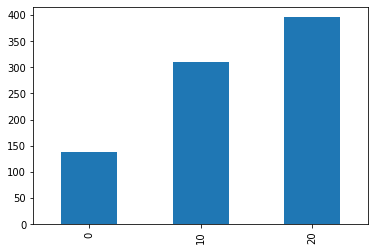

In [8]:
labeled_data.rating.value_counts(sort=False).plot(kind="bar")

-> we have imbalanced (and generally too less) data, therefore up-sampling will be applied after Train/Test split.

## Sentiment Assignment

ML-based approach.

### Train/Test-Split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(labeled_data.cleaned_txt, labeled_data.rating,
                                                    test_size=0.2, random_state=random_state)

print("X shapes (train/test):", X_train.shape, "/", X_test.shape)
print("y shapes (train/test):", y_train.shape, "/", y_test.shape)

X shapes (train/test): (676,) / (169,)
y shapes (train/test): (676,) / (169,)


#### Up-Sampling

In [10]:
X_samples = pd.concat([X_train, y_train], axis=1)
print(X_samples.shape)
X_samples.rating.value_counts(sort=False)

(676, 2)


0     109
10    242
20    325
Name: rating, dtype: int64

Up-sample positive (2x, with text shuffle and random word skipping)

In [11]:
skip_frac = 0.1 # Fraction of words to be skipped from text during up-sampling

def shuffle_and_skip(txt, frac):
    """ Removes fraction of words in text and shuffles word order. """
    words = txt.split()
    sampled_words = random.sample(words, int(len(words) * (1 - frac)))
    random.shuffle(sampled_words)
    return " ".join(sampled_words)

positive_upsamples = X_samples[X_samples.rating == 0]
positive_upsamples.cleaned_txt = positive_upsamples.cleaned_txt.apply(lambda x: shuffle_and_skip(x, skip_frac))

X_upsampled = pd.concat([X_samples, positive_upsamples], axis=0)
print(X_upsampled.shape)
X_upsampled.rating.value_counts(sort=False)

(785, 2)


/home/datadonk23/anaconda3/envs/WBNRW19/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


0     218
10    242
20    325
Name: rating, dtype: int64

In [12]:
X_train = X_upsampled.cleaned_txt
y_train = X_upsampled.rating

### Vectorizer

In [13]:
tfidf = TfidfVectorizer(lowercase=False, # already lowercased
                        tokenizer=word_tokenize) 
                        #max_features=3500) # tune max_features for generalization eventually

### Models

In [14]:
logreg = LogisticRegression(random_state=random_state, n_jobs=-1)
svc = LinearSVC(random_state=random_state)
nb = MultinomialNB()
rf = RandomForestClassifier(random_state=random_state, n_jobs=-1)
nn = MLPClassifier(learning_rate="adaptive", solver="adam", random_state=random_state)

models = [logreg, svc, nb, rf, nn]

Parameters

In [15]:
params = {}
params["LogisticRegression"] = {"penalty": ["l1", "l2"],
                                "C": [0.01, 0.1, 0.5, 1., 4.3, 7.5],
                                "class_weight": [None, "balanced"]}
params["LinearSVC"] = {"C": [0.01, 0.1, 0.38, 1., 10., 20.],
                       "class_weight": [None, "balanced"]}
params["MultinomialNB"] = {"alpha": [0., 0.01, 0.1, 1.],
                           "fit_prior": [True, False]}
params["RandomForestClassifier"] = {"n_estimators": [2, 64, 97, 100, 128],
                                    "criterion": ["gini", "entropy"],
                                    "min_samples_leaf": [1, 2],
                                    "max_features": [None, "auto"],
                                    "class_weight": [None, "balanced"]}
params["MLPClassifier"] = {"alpha": [0.0001, 0.0005],
                           "learning_rate_init": [0.001, 0.005]}

### Pipeline

In [16]:
classifiers = {}

for model in models:
    classifiers[type(model).__name__ + "_pipe"] = Pipeline([
        ("tfidf", tfidf),
        ("clf", GridSearchCV(model, param_grid=params[type(model).__name__],
                             scoring="accuracy", cv=5, refit=True, n_jobs=-1))
    ])

Train

In [17]:
for _, clf_pipeline in classifiers.items():
    clf_pipeline.fit(X_train, y_train)

/home/datadonk23/anaconda3/envs/WBNRW19/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/datadonk23/anaconda3/envs/WBNRW19/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/datadonk23/anaconda3/envs/WBNRW19/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/datadonk23/anaconda3/envs/WBNRW19/lib/python3.7/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/datadonk23/anac

Predict

In [18]:
best_acc = 0
best_model_pipe = None

for name, clf_pipeline in classifiers.items():
    y_pred = clf_pipeline.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(acc, name, clf_pipeline.named_steps["clf"].best_params_)
    
    if acc > best_acc:
        best_model_pipe = clf_pipeline
        best_acc = acc

0.6272189349112426 LogisticRegression_pipe {'C': 4.3, 'class_weight': None, 'penalty': 'l2'}
0.6094674556213018 LinearSVC_pipe {'C': 0.38, 'class_weight': None}
0.5739644970414202 MultinomialNB_pipe {'alpha': 0.0, 'fit_prior': True}
0.47337278106508873 RandomForestClassifier_pipe {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': None, 'min_samples_leaf': 2, 'n_estimators': 97}
0.5739644970414202 MLPClassifier_pipe {'alpha': 0.0001, 'learning_rate_init': 0.001}


## Evaluation

In [19]:
class_encoding = {0: "positive", 10: "neutral", 20: "negative"}

#### Confusion Matrix

/home/datadonk23/anaconda3/envs/WBNRW19/lib/python3.7/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


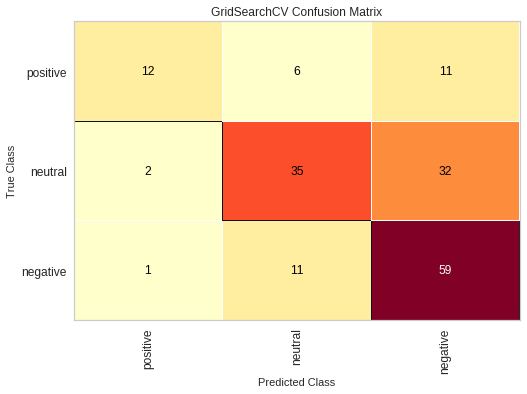

In [20]:
from yellowbrick.classifier import ConfusionMatrix, ClassificationReport, PrecisionRecallCurve, ROCAUC

cm = ConfusionMatrix(best_model_pipe, is_fitted=True, encoder=class_encoding)
cm.score(X_test, y_test)
cm.poof()

#### Classification Report

              precision    recall  f1-score   support

           0       0.80      0.41      0.55        29
          10       0.67      0.51      0.58        69
          20       0.58      0.83      0.68        71

    accuracy                           0.63       169
   macro avg       0.68      0.58      0.60       169
weighted avg       0.66      0.63      0.62       169



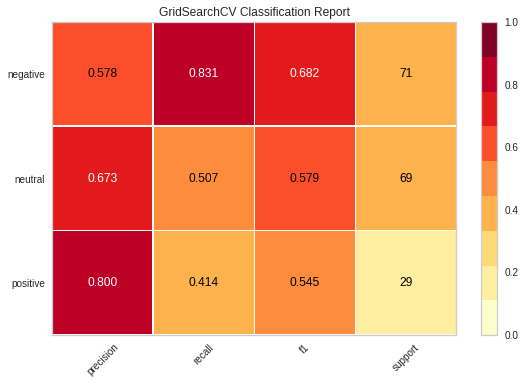

In [21]:
print(classification_report(y_test, best_model_pipe.predict(X_test)))

# Visualizer
report = ClassificationReport(best_model_pipe, is_fitted=True, encoder=class_encoding, support=True)
report.score(X_test, y_test)
report.poof()

#### Precision-Recall Curve

/home/datadonk23/anaconda3/envs/WBNRW19/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/datadonk23/anaconda3/envs/WBNRW19/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/datadonk23/anaconda3/envs/WBNRW19/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/datadonk23/anaconda3/envs/WBNRW19/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify

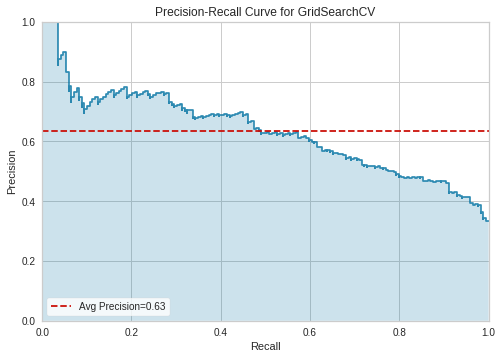

In [22]:
pr_curve = PrecisionRecallCurve(best_model_pipe)
pr_curve.fit(X_train, y_train)
pr_curve.score(X_test, y_test)
pr_curve.poof()

#### ROCAUC

/home/datadonk23/anaconda3/envs/WBNRW19/lib/python3.7/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


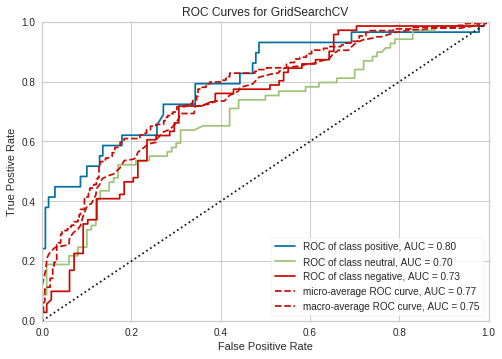

In [23]:
rocauc = ROCAUC(best_model_pipe, is_fitted=True, encoder=class_encoding)
rocauc.score(X_test, y_test)
rocauc.poof()

# Conclusion

Expectedly there's an improvement in accuracy (after skipping "offensive" as class). The current best model (LogReg) comes close to an accuracy score, where a deployment in production can be considered (for this case, >0.7). Perhaps this can be reached with some additional fine tuning of the model parameter. More productive should be anyhow to (a) get more data (esp. "positive" samples, as the current model performs only in this class insufficiently) and (b) enhance NLP Pipeline.